# Prezicerea satisfacției față de o companie aeriană cu ajutorul Deep Learning

Vom încerca să prezicem una dintre cele două valori ale coloanei țintă **satisfaction** (**satisfied** sau **neutral or dissatisfied**) cu ajutorul rețelelor neuronale adânci.

Am ales această abordare atât datorită creșterii în popularitate și performanță a metodelor Deep Learning cât și datorită librăriilor Keras și Tensorflow din Python care oferă API-uri ușor de folosit pentru construirea rețelelor neuronale.

In [ ]:
import numpy as np
import pandas as pd

airline = pd.read_csv("/content/drive/MyDrive/Proiect Big Data/airline_satisfaction.csv")
airline.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


## Pregătirea datelor

In [ ]:
# numărarea de valori null
airline.isna().sum()

Unnamed: 0                             0
id                                     0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             310
satisfaction    

In [ ]:
# eliminarea liniilor cu valori null și a coloanelor Unnamed: 0 și id
airline.dropna(inplace=True)
airline.drop(columns=["Unnamed: 0", "id"], inplace=True)

In [ ]:
# encodarea variabilelor categoriale
numeric_features = pd.get_dummies(airline, columns=["Gender", "Customer Type", "Type of Travel", "Class"])
numeric_features.head()

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,...,satisfaction,Gender_Female,Gender_Male,Customer Type_Loyal Customer,Customer Type_disloyal Customer,Type of Travel_Business travel,Type of Travel_Personal Travel,Class_Business,Class_Eco,Class_Eco Plus
0,13,460,3,4,3,1,5,3,5,5,...,neutral or dissatisfied,0,1,1,0,0,1,0,0,1
1,25,235,3,2,3,3,1,3,1,1,...,neutral or dissatisfied,0,1,0,1,1,0,1,0,0
2,26,1142,2,2,2,2,5,5,5,5,...,satisfied,1,0,1,0,1,0,1,0,0
3,25,562,2,5,5,5,2,2,2,2,...,neutral or dissatisfied,1,0,1,0,1,0,1,0,0
4,61,214,3,3,3,3,4,5,5,3,...,satisfied,0,1,1,0,1,0,1,0,0


In [ ]:
# convertirea coloanei satisfaction în 0 și 1
numeric_features["satisfaction"] = numeric_features["satisfaction"].replace({"satisfied": 1, "neutral or dissatisfied": 0})

# extragerea coloanelor features și target
X = numeric_features.drop(columns=["satisfaction"])
y = numeric_features["satisfaction"]

print(X.shape)
print(y.shape)

(103594, 27)
(103594,)


## Împărțirea setului de date în antrenare, validare și testare

In [ ]:
from sklearn.model_selection import train_test_split

X_rest, X_test, y_rest, y_test = train_test_split(X, y, test_size=0.2, random_state=100, stratify=y)
X_train, X_valid, y_train , y_valid = train_test_split(X_rest, y_rest, test_size=0.2, random_state=100, stratify=y_rest)

print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(66300,)
(16575,)
(20719,)


## Definirea modelului

Vom crea o rețea neuronală cu un strat de intrare cu 128 de neuroni, 2 straturi ascunse a câte 64, respectiv 32 de neuroni și un start de ieșire cu 1 neuron ce va prezice probabilitatea ca pasagerul să fie satisfăcut.

Toate straturile vor avea *Relu* ca funcție de activare cu excepția stratului de ieșire care va avea *Sigmoid*.

De asemenea, vom aplica între straturi un mecanism de regularizare cu ajutorul unor straturi de tip *Dropout* pentru a evita overfitting-ul.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(units=128, activation="relu", input_shape=(27,)))
model.add(Dropout(0.5))
model.add(Dense(units=64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=32, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation="sigmoid"))

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])

## Antrenarea modelului

In [ ]:
# antrenarea modelului pe 70 de epoci
history = model.fit(x=X_train, y=y_train, epochs=70, validation_data=(X_valid, y_valid))

Epoch 1/70
2072/2072 [==============================] - 7s 3ms/step - loss: 3.4030 - accuracy: 0.5654 - val_loss: 0.6756 - val_accuracy: 0.5666
Epoch 2/70
2072/2072 [==============================] - 7s 3ms/step - loss: 0.6751 - accuracy: 0.6076 - val_loss: 0.6612 - val_accuracy: 0.6094
Epoch 3/70
2072/2072 [==============================] - 6s 3ms/step - loss: 0.6676 - accuracy: 0.6117 - val_loss: 0.6685 - val_accuracy: 0.5668
Epoch 4/70
2072/2072 [==============================] - 7s 3ms/step - loss: 0.6642 - accuracy: 0.6185 - val_loss: 0.6569 - val_accuracy: 0.6141
Epoch 5/70
2072/2072 [==============================] - 6s 3ms/step - loss: 0.6427 - accuracy: 0.6453 - val_loss: 0.5757 - val_accuracy: 0.7385
Epoch 6/70
2072/2072 [==============================] - 7s 3ms/step - loss: 0.5203 - accuracy: 0.7593 - val_loss: 0.4786 - val_accuracy: 0.8064
Epoch 7/70
2072/2072 [==============================] - 6s 3ms/step - loss: 0.4553 - accuracy: 0.8066 - val_loss: 0.4011 - val_accuracy:

Text(0, 0.5, 'loss')

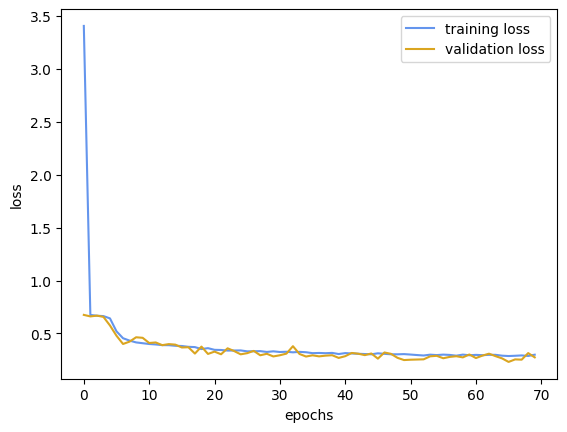

In [ ]:
import matplotlib.pyplot as plt

# observăm evoluția funcției de loss a seturilor de antrenare și validare pe parcursul epocilor
plt.plot(history.history["loss"], c="cornflowerblue", label="training loss")
plt.plot(history.history["val_loss"], c="goldenrod", label="validation loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")

## Evaluarea modelului

In [ ]:
# calcularea predicțiilor
y_pred = (model.predict(X_test) > 0.5).reshape((-1,))

# afișare classification report pentru metrici precum precision, recall, f1 pentru fiecare clasă
# și metrici globale precum accuracy
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

648/648 [==============================] - 1s 1ms/step
              precision    recall  f1-score   support

           0       0.83      0.99      0.90     11740
           1       0.98      0.74      0.84      8979

    accuracy                           0.88     20719
   macro avg       0.91      0.86      0.87     20719
weighted avg       0.90      0.88      0.88     20719



(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

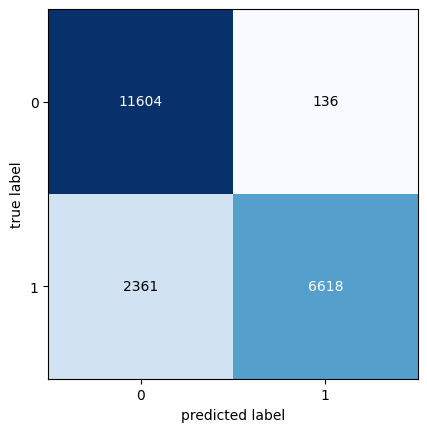

In [ ]:
# afișarea matricei de confuzie
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

conf = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf)

Din metricile de mai sus putem observa că modelul este sensibil la fals negative, fiind un număr semnificativ de instanțe când pasageri satisfăcuți au fost preziși ca neutrii sau nesatisfăcuți.

Precizia este foarte bună pentru clasa "satisfied", în timp ce pentru clasa "neutral or dissatisfied" excelează recall-ul.

Acuratețea de 88% se poziționează între rezultatele obținute cu Regresia Logistică având parametrii default și Random Forest cu optimizarea hiperparametrilor.